In [1]:
import os, sys
sys.path.append('/home/jp/projects/python_tools')
import matplotlib.pyplot as plt
import numpy as np
import jp_mpl as jplot
%matplotlib inline  
import pickle
import itertools

### Creating a new reflection model (keeping reflectivity and absorption)

In [2]:
# PMT details
pmt_surfacer = 99.1 #mm
gdisc_radius = 137.7 #mm

# Presuming that the diagram in Moffat's thesis is correct
conversion = 315.2/458 # px to mm -- 458 px = 315.2 mm
pmt_radius = 327/2.*conversion
conc_radius = 455/2.*conversion
pmtdepth = 82*conversion

In [3]:
# The concentrator is more of an ellipse
b = 383 #px minor axis
a = 437 #px major axis
# The center is at the center of the disc#
# The PMT starts 82 pixels into the disc position

In [4]:
print b*conversion/2.
print 474*conversion/2.
print 'Depth of the intersection', 158*conversion

131.792139738
163.105676856
Depth of the intersection 108.737117904


In [5]:
# From r = [0, pmt_surfacer]
# For r > disc_radius
### Ellipse equation
# x**2/a**2 + y**2/b**2 = 1
def ellipse_y(x, majaxis = a*conversion/2.-12, minaxis = gdisc_radius):
    return -np.sqrt(minaxis**2*(1. - x**2/majaxis**2))
def circle(x, r = pmt_radius):
    return +np.sqrt(r**2 - x**2)

(-110, 0)

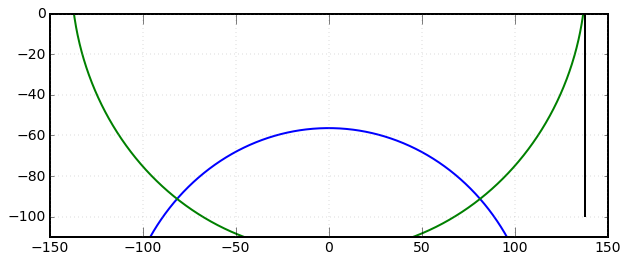

In [6]:
plt.figure(figsize=(10,4))
x2 = np.linspace(-pmt_radius, pmt_radius, 1000)
plt.plot(x2, circle(x2)-pmtdepth-pmt_radius)

x = np.linspace(-gdisc_radius, gdisc_radius, 1000)
plt.plot(x,ellipse_y(x)+20)
plt.vlines(gdisc_radius, -100, 0)
plt.ylim([-110, 0])
#plt.axis('equal')

In [7]:
def plotPhotonPath(p, d):

    plt.figure(figsize=(10,4))
    colors = itertools.cycle(['r','g','b','c','m'])

    x = np.linspace(-gdisc_radius, gdisc_radius, 100000)


    for iStep in range(len(d)-1):
        # The normal
        myc = next(colors)
        plt.quiver(p[iStep+1][0], 
                   opticalSurface(np.array([p[iStep+1][0]])),
                  *opticalNormal(p[iStep+1][0]), scale=10,color='k')

        # The incoming
        plt.quiver(p[iStep+1][0], p[iStep+1][1], d[iStep][0], d[iStep][1],
                  color = myc, scale = 1, pivot='tip')    

    # Last outgoing
    plt.quiver(p[-1][0], p[-1][1], d[-1][0], d[-1][1],
                color = next(colors), scale = 2) 



    y = opticalSurface(x)
    plt.plot(x, y)

In [8]:
pmt_surfacer = 82
def opticalSurface(x):
    # Treat x as an array
    xpmt  = np.abs(x)<pmt_surfacer
    y = np.zeros_like(x)
    
    #print xpmt
    
    # The PMT
    y[xpmt] = np.sqrt(pmt_radius**2-x[xpmt]**2)-pmtdepth-pmt_radius
    
    # The concentrator
    y[~xpmt] = 20.-np.sqrt(gdisc_radius**2*(1.-x[~xpmt]**2/(a*conversion/2.-12.)**2))
    
    return y

In [9]:
def opticalNormal(x, step = 0.001):
    x1 = x
    y1 = opticalSurface(np.array([x1]))

    x2 = x+step
    y2 = opticalSurface(np.array([x2]))
    
    pvec = np.array([(y1-y2)[0], step])
    
    return pvec/np.sqrt(np.sum(pvec**2))

def trackPoints(inpos, indir,
                maxy = 0, miny = -100, 
                stepsize = 0.01, verbose = False):
    
    # Check in how many steps I'll be surely out
    # If you start above zero, calculate to the bottom
    if inpos[1] > maxy:
        if verbose: print 'Calculating bottom'
        n = (miny - inpos[1])/(indir[1]*stepsize)
    # If you're inside the volume, calculate bottom and top
    else:
        # If are traveling down, calculate the bottom
        if indir[1] < 0:
            if verbose: print 'Calculating bottom'
            n =  (miny - inpos[1])/(indir[1]*stepsize)
        # If you are traveling up, calculate top
        else:
            if verbose: print 'Calculating top'
            n = (maxy - inpos[1])/(indir[1]*stepsize)

    if n > 1000000:
        print n
        return [], []
    #else:
        #print 'Nsteps', n
    
    x = inpos[0] + indir[0]*stepsize*np.arange(10,n, 1)
    y = inpos[1] + indir[1]*stepsize*np.arange(10,n, 1)
    
    return x, y

def trackPhotonStep(inpos, indir,
                   verbose =False):#, outpos, outdir):
    tolerance = 0.05
    indir /= np.sqrt(np.sum(indir**2))
    x,y = trackPoints(inpos, indir, verbose)
    if len(x) == 0:
        print 'Infinite tracking'
        return []
    contact = False
    for i, one_x in enumerate(x):
        # The top is at zero
        if np.abs(y[i]) < tolerance and indir[1] > 0:
            if verbose: print 'Photon is leaving'
            break
        
        # The problem is here ... not moving and passes the condition
        ysurf = opticalSurface(np.array([one_x]))
        if np.abs(ysurf-y[i]) < tolerance:
            contact = True
            break
    #print 'This is the x,y of contact',one_x, y[i]
    if contact:
        normal = opticalNormal(one_x)
        if verbose: print 'Normal', normal
        outpos = np.array([one_x, y[i]])

        # Getting the reflection angle
        #costheta = np.dot(normal, indir)
        #theta  = np.arccos(-1.*costheta)
        
        # Flip the theta sign when arriving from the left of the normal vector
        
        #theta = np.arctan2(-indir[1], -indir[0]) - np.arctan2(normal[1], normal[0]);
        theta = np.arctan2(np.cross(-indir,normal), np.dot(-indir, normal))
        
        #if (-indir[0] < normal[0]):
        # When arriving from the left side of the normal
        #if (normal[0] - indir[0]):
        #if indir[1]<0 and (normal[0]> indir[0]):
        #    if verbose: print 'Flipping sign'
        #    theta *= -1.
        

        outdir = np.array([normal[0]*np.cos(theta) - normal[1]*np.sin(theta),
                           normal[0]*np.sin(theta) + normal[1]*np.cos(theta)])
        outdir /= np.sqrt(np.sum(outdir**2))
        if verbose: print 'Angle', theta, np.cos(theta), np.sin(theta)

        
        return [outpos, outdir]
    else:
        if verbose: print 'Photon is outside'
        return []

In [10]:
def trackPhoton(inpos, indir, verbose=False):
    indir /= np.sqrt(np.sum(indir**2))
    positions =  []
    directions = []
    count_tol  = 10
    
    positions.append(inpos)
    directions.append(indir)
    out = trackPhotonStep(inpos, indir, verbose)
    counter = 0
    while len(out) > 0 and counter < count_tol:
        counter += 1
        positions.append(out[0])
        directions.append(out[1])
        #print 'pos\n', positions
        #print 'dir\n', directions
        out = trackPhotonStep(out[0], out[1], verbose)
        #raw_input()
        
    if counter >= count_tol:
        print 'Photon stuck'
    
    print 'Steps ', len(positions)
    return positions, directions

In [11]:
p, d = trackPhoton(np.array([-20, 5]),
                   np.array([0.1, -10]),
                  True)
print d

Normal [-0.17213332  0.98507366]
Angle 0.162995235106 0.986745660185 0.162274465354
Photon is leaving
Photon is outside
Steps  2
[array([ 0.0099995, -0.99995  ]), array([-0.3297041 ,  0.94408432])]


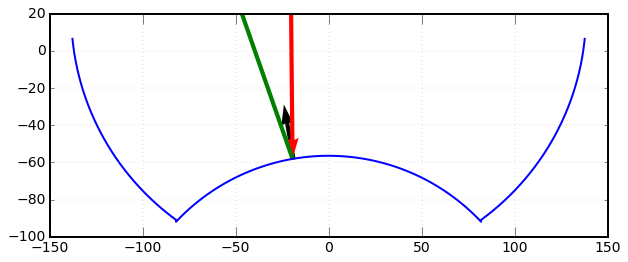

In [12]:
plotPhotonPath(p,d)
# Coming from the right of the normal looks fine

In [13]:
# Start by modifying the shooting point in x

In [14]:
outdir_list = {}

In [15]:
initial_dir = np.array([1.,-8])
initial_angle = np.arctan2(-initial_dir[0], -initial_dir[1])
print np.rad2deg(initial_angle)

-7.1250163489


In [26]:

xpositions  = np.linspace(-gdisc_radius+1, gdisc_radius-1, 70)
out_angle   = np.zeros_like(xpositions)
plist = []
dlist = []
for iPos, xpos in enumerate(xpositions):
    print 'Point', iPos,
    ptmp, dtmp = trackPhoton(np.array([xpos, 10]),
                             initial_dir)
    plist.append(ptmp)
    dlist.append(dtmp)
    out_angle[iPos]  = np.arctan2(dtmp[-1][0], dtmp[-1][1])
outdir_list[initial_angle] = out_angle    



Point 0 Steps  6
Point 1 Steps  6
Point 2 Steps  3
Point 3 Steps  3
Point 4 Steps  3
Point 5 Steps  3
Point 6 Steps  3
Point 7 Steps  3
Point 8 Steps  3
Point 9 Steps  3
Point 10 Steps  3
Point 11 Steps  3
Point 12 Steps  3
Point 13 Steps  3
Point 14 Steps  3
Point 15 Steps  3
Point 16 Steps  3
Point 17 Steps  3
Point 18 Steps  3
Point 19 Steps  2
Point 20 Steps  2
Point 21 Steps  2
Point 22 Steps  2
Point 23 Steps  2
Point 24 Steps  2
Point 25 Steps  2
Point 26 Steps  2
Point 27 Steps  2
Point 28 Steps  2
Point 29 Steps  2
Point 30 Steps  2
Point 31 Steps  2
Point 32 Steps  2
Point 33 Steps  2
Point 34 Steps  2
Point 35 Steps  2
Point 36 Steps  2
Point 37 Steps  2
Point 38 Steps  2
Point 39 Steps  2
Point 40 Steps  2
Point 41 Steps  2
Point 42 Steps  2
Point 43 Steps  2
Point 44 Steps  3
Point 45 Steps  3
Point 46 Steps  3
Point 47 Steps  3
Point 48 Steps  3
Point 49 Steps  3
Point 50 Steps  3
Point 51 Steps  3
Point 52 Steps  1
Point 53 Steps  3
Point 54 Steps  3
Point 55 Steps  3
Po

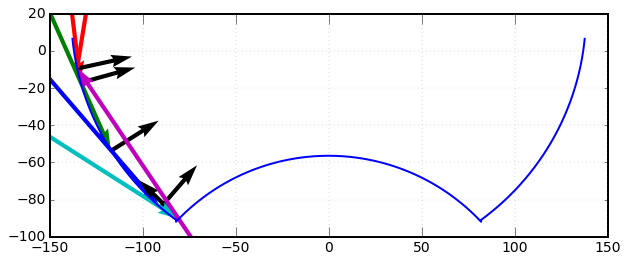

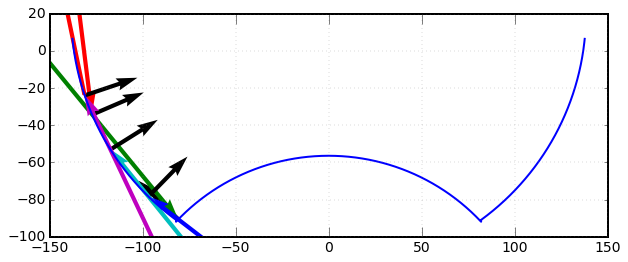

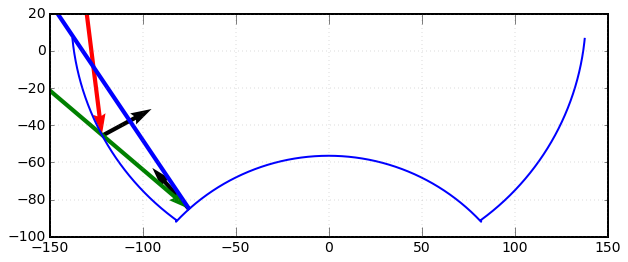

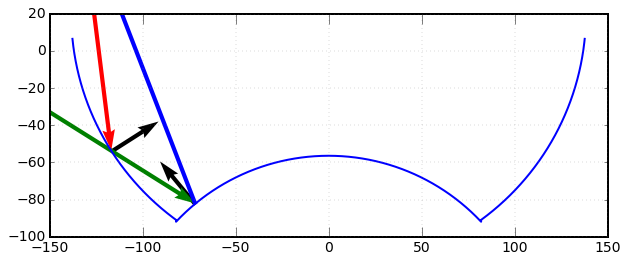

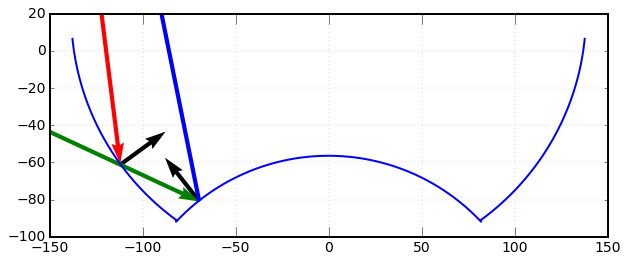

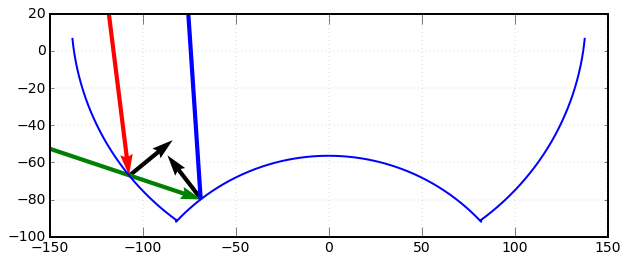

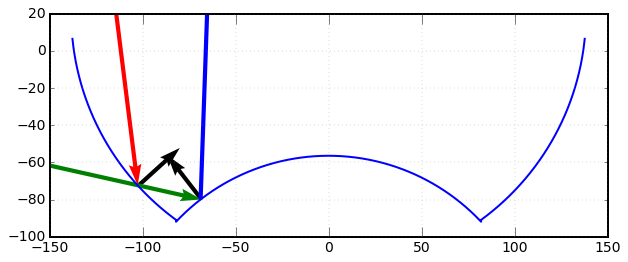

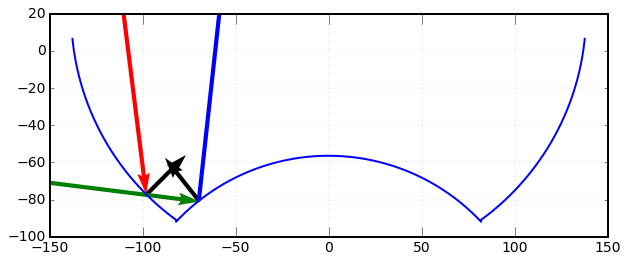

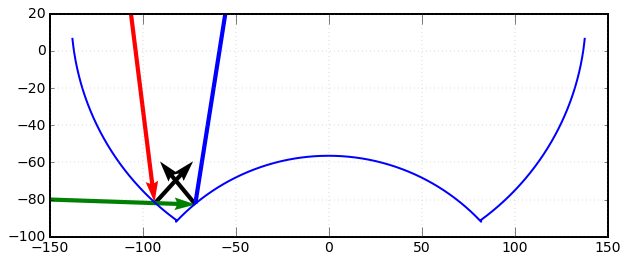

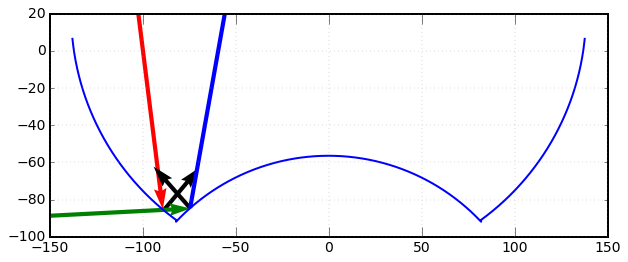

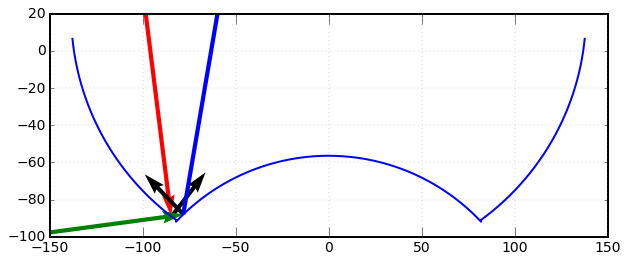

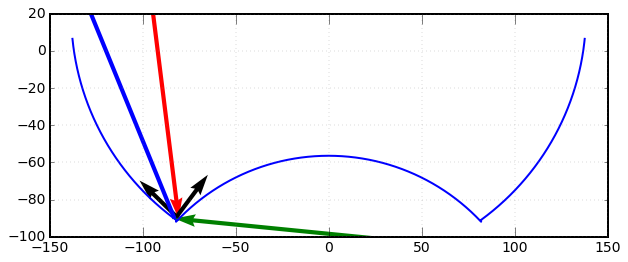

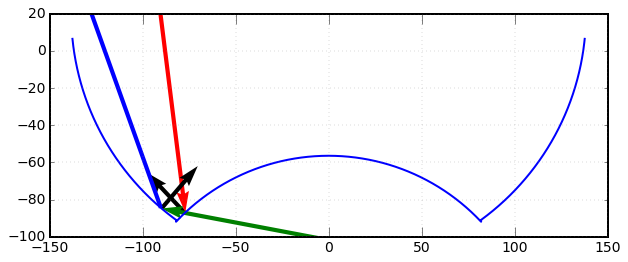

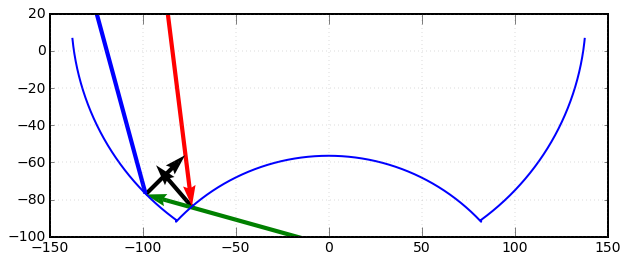

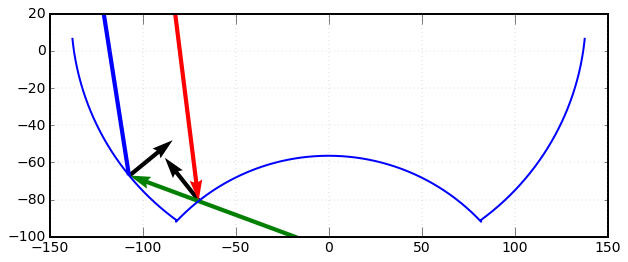

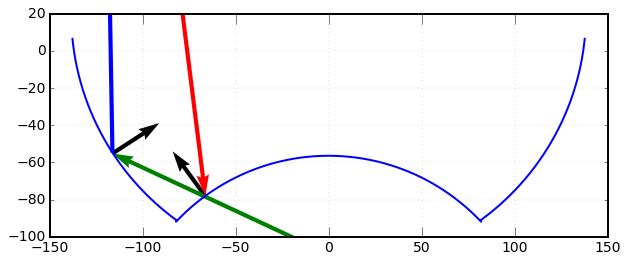

KeyboardInterrupt: 

In [17]:
for iStep in range(len(plist)):
    plotPhotonPath(plist[iStep],dlist[iStep])
    
    plt.show()
    raw_input()
    
    

In [451]:
allkeys = np.rad2deg(outdir_list.keys())
allkeys.sort()
print allkeys


[ -8.42894069e+01  -7.33007558e+01  -6.34349488e+01  -5.90362435e+01
  -5.50079798e+01  -5.13401917e+01  -4.50000000e+01  -3.98055711e+01
  -3.09637565e+01  -1.66992442e+01  -5.72957604e-02]


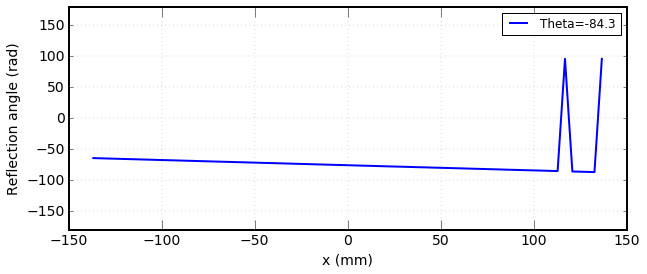

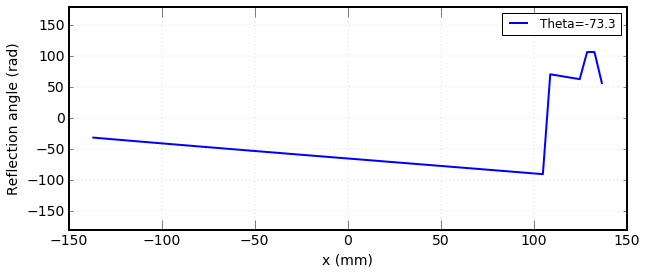

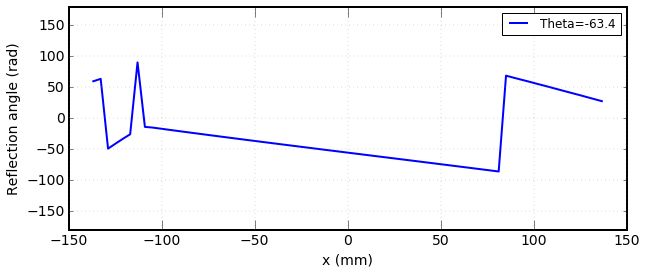

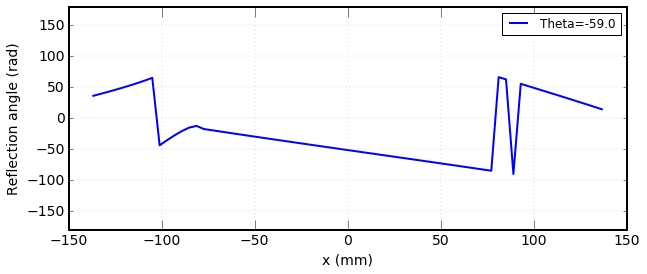

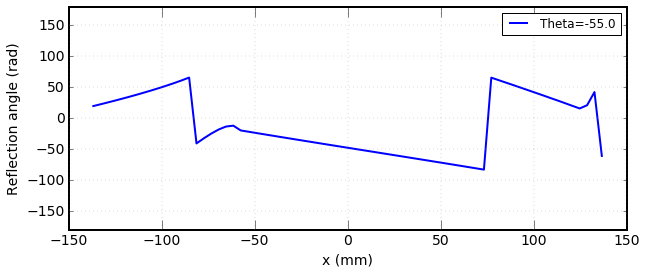

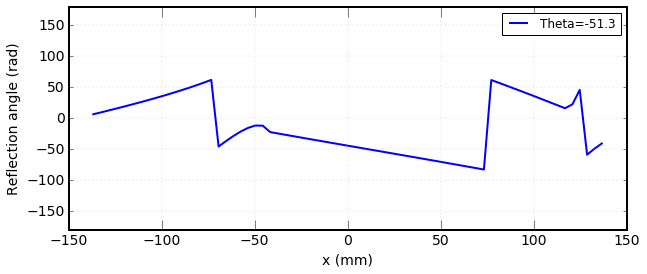

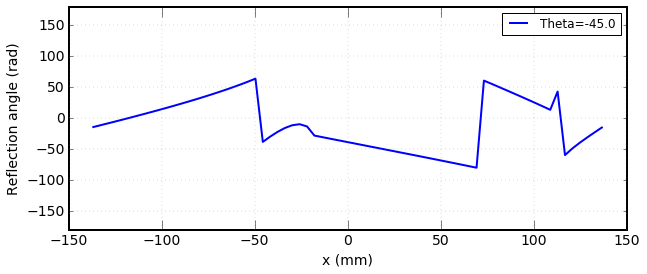

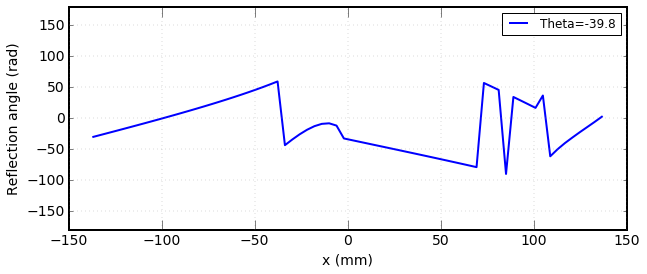

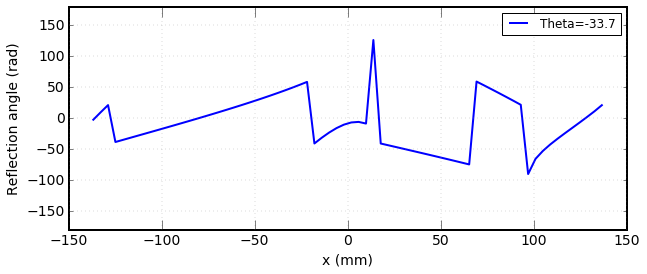

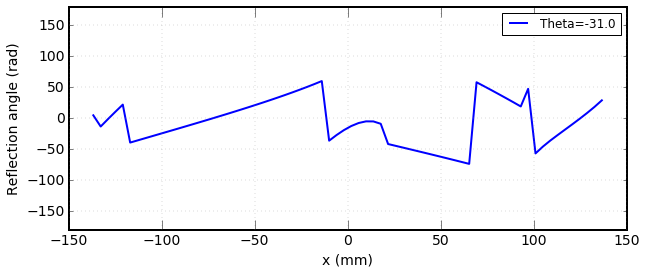

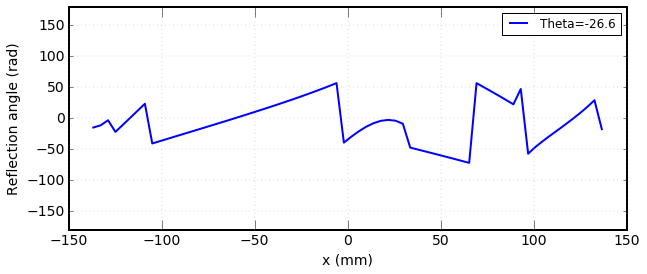

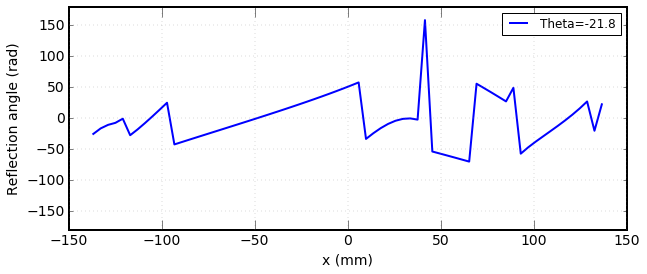

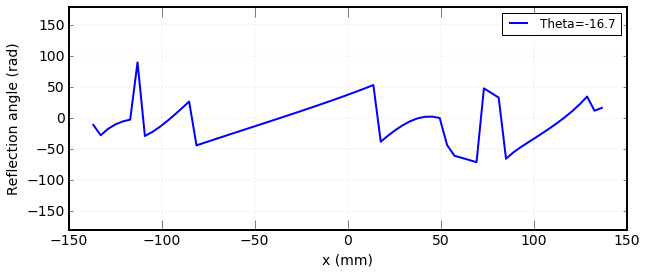

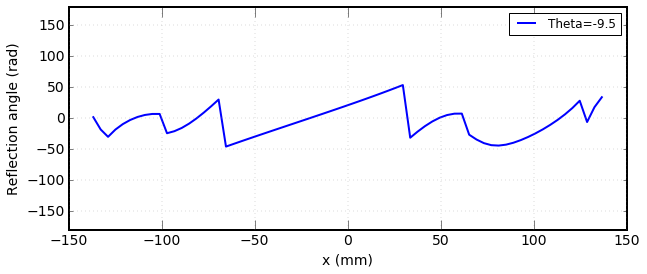

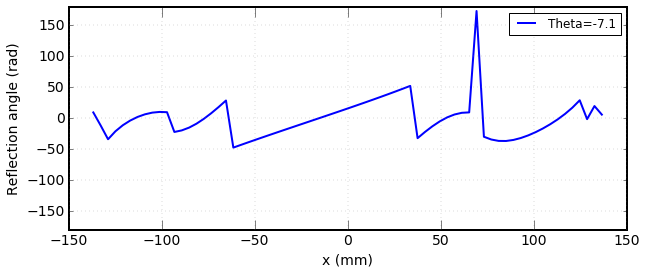

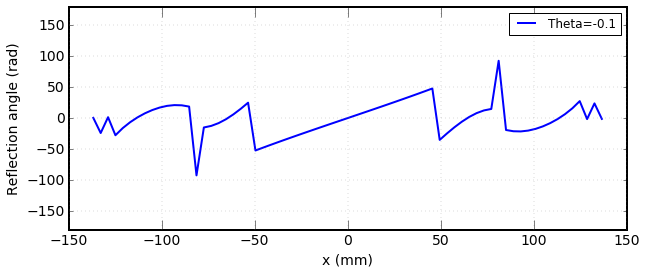

In [471]:
# The regions that I trust are
ordered_keys=outdir_list.keys()
ordered_keys.sort()
all_angles =np.zeros(1)
for one_key in ordered_keys:
    #if one_key < np.deg2rad(-50): continue
    plt.figure(figsize=(10,4))
    all_angles = np.concatenate((all_angles,outdir_list[one_key]))
    plt.plot(xpositions,np.rad2deg(outdir_list[one_key]),
            label = 'Theta='+"%.1f" % np.rad2deg(one_key))
    plt.xlabel('x (mm)')
    plt.ylabel('Reflection angle (rad)')
    plt.ylim([-180,180])
    plt.legend(loc=0)

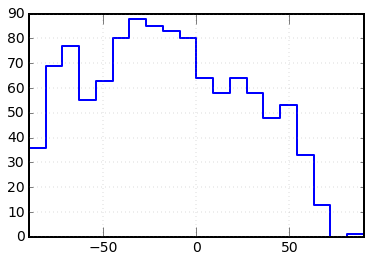

In [474]:
x = np.linspace(-90,90,21)
n, x = np.histogram(np.rad2deg(all_angles),x)
jplot.unfilledBar(x,n)

### Model 1

In [515]:
# What happens if I want to do it dependent only on incident angle?
# Integrating over the disc radius
newx = []
newy = []
for one_key in outdir_list.keys():
    newx.append(np.cos(one_key))
    xbool = xpositions<0
    newy.append( 
        np.sum(outdir_list[one_key][xbool]*xpositions[xbool])/
        np.sum(xpositions[xbool]))
    

Lets call this model 0
       4         3         2
29.64 x - 67.66 x + 47.82 x - 9.266 x - 0.6694


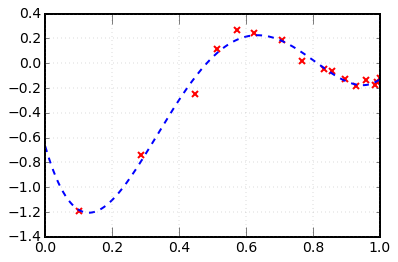

In [524]:
plt.plot(newx, newy, 'xr')
fcn = np.poly1d(np.polyfit(newx, newy, deg=4))

smoothx = np.linspace(0, 1, 1000)
plt.plot(smoothx, fcn(smoothx), '--b')
print 'Lets call this model 1' # Keep the phi specular for model 0
print fcn

### Model 2 - not weighting by r

In [525]:
# What happens if I want to do it dependent only on incident angle?
# Integrating over the disc radius
newx = []
newy = []
for one_key in outdir_list.keys():
    newx.append(np.cos(one_key))
    xbool = xpositions<0
    newy.append( outdir_list[one_key][xbool].mean())

Lets call this model 0
        3         2
-4.261 x + 4.272 x + 1.196 x - 1.397


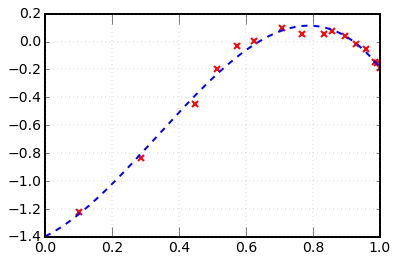

In [529]:
plt.plot(newx, newy, 'xr')
fcn = np.poly1d(np.polyfit(newx, newy, deg=3))

smoothx = np.linspace(0, 1, 1000)
plt.plot(smoothx, fcn(smoothx), '--b')
print 'Lets call this model 2' # Keep the phi specular for model 0
print fcn

### Model 3 <br> Looks like I need something more complex. Could I start looking at the position in r now?

Could start by doing the large angles first. Then go for the small angles.<br>
I need to move the laserball towards the bottom and test.<br>
How about the occupancy as function of z position in the detector? that could also be interesting